In [41]:
import keras
from keras import layers
import tensorflow as tf
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

In [42]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [43]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train.shape

(60000, 28, 28)

In [102]:
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))

x_train.shape

(60000, 28, 28, 1)

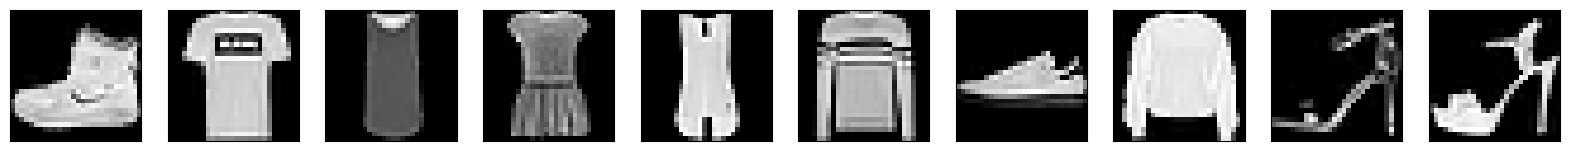

In [47]:
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [73]:
inputs = keras.Input(shape=(28,28,1))
encoded = layers.Conv2D(32, (3,3), activation='relu', padding='same',)(inputs)
encoded = layers.Conv2D(64, (3,3), activation='relu', padding='same',)(encoded)
encoded = layers.Conv2D(128, (3,3), activation='relu', padding='same',)(encoded)
re_shape = K.int_shape(encoded)
encoded = layers.Flatten()(encoded)
mean = layers.Dense(2)(encoded)
sigma = layers.Dense(2)(encoded)

In [74]:
def sampling(args):
    mean, sigma = args
    epsi = K.random_normal(shape=(K.shape(mean)[0], 2), mean=0.0, stddev=1.0)
    return mean + K.exp(sigma)*epsi

z = layers.Lambda(sampling)([mean, sigma])
    
    

In [100]:
encoded_inputs = keras.Input(K.int_shape(z)[1:])
decoded = layers.Dense(np.prod(re_shape[1:]), activation='relu')(encoded_inputs)
decoded = layers.Reshape(re_shape[1:])(decoded)
decoded = layers.Conv2DTranspose(64, (2,2), activation='relu', padding='same',)(decoded)
decoded = layers.Conv2DTranspose(32, (2,2), activation='relu', padding='same',)(decoded)
decoded = layers.Conv2D(1,(3,3), activation='sigmoid', padding='same',)(decoded)

encoder = keras.Model(inputs, [mean, sigma, z], name='encoder')
decoder = keras.Model(encoded_inputs, decoded, name='decoder')

v_autoencoder = keras.Model(inputs, decoder(encoder(inputs)[2]), name='variational_autoencoder')

v_autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "variational_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               494084    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         342401    
                                                                 
Total params: 836,485
Trainable params: 836,485
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         

In [52]:
tf.keras.utils.plot_model(v_autoencoder,"model.png", show_shapes = True,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [80]:
x_train=x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test=x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

In [81]:
x_train.shape

(60000, 784)

In [103]:
r_loss = keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(decoder(encoder(inputs)[2])))*784
kl_loss = (-1/2)*K.sum(1+sigma+K.square(mean)-K.exp(sigma), axis=1)
variational_loss = K.mean(kl_loss + 1000*r_loss)
v_autoencoder.add_loss(variational_loss)

v_autoencoder.add_metric(kl_loss, name="kl_loss")
v_autoencoder.add_metric(r_loss, name="reconstruction_loss")



In [106]:
v_autoencoder.compile(optimizer='adam', metrics=['accuracy'])

In [107]:
v_autoencoder.fit(x_train, x_train, batch_size=256, epochs=500, validation_data=(x_test, x_test))

Epoch 1/500
235/235 [==============================] - 258s 1s/step - loss: nan - accuracy: 0.4915 - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_accuracy: 0.4999 - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 2/500
235/235 [==============================] - 252s 1s/step - loss: nan - accuracy: 0.5021 - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_accuracy: 0.4999 - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 3/500
235/235 [==============================] - 270s 1s/step - loss: nan - accuracy: 0.5021 - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_accuracy: 0.4999 - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 4/500
235/235 [==============================] - 309s 1s/step - loss: nan - accuracy: 0.5021 - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_accuracy: 0.4999 - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 5/500
235/235 [==============================] - 306s 1s/step - loss: nan 

KeyboardInterrupt: 